This notebook plots the potential variable importance held by each query neighborhood.
The numbers substantially increase, which is somewhat expected given that many of the important hashes encoded 16s/23s, which should be co-located in the graph.

In [1]:
setwd("..")

In [3]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(rjson)
library(ggplot2)
library(ggtree)
library(aplot)

### read in gather results to get shared assemblies

+ read in gtdb derep + genbank protozoa, fungi, viral gather results.
+ subset to assemblies identified in all models. 
+ summarize to species level to group queries of the same species together.
+ Then, summarize the variable importance held by each genome and plot.

In [4]:
# read in gather results and subset to accessions shared between all models
# gather_files <- snakemake@input[["gather"]]
# gather_files <- unlist(gather_files, use.names=FALSE)
gather_pangenome_files <- Sys.glob("outputs/sgc_pangenome_gather/*pangenome_nbhd_reads.csv")
gather_pangenome_results <- gather_pangenome_files %>%
  set_names() %>%
  map_dfr(read_csv, col_types = c("dddddlllcccddddcccd"), .id = "source")  %>%
  mutate(source = gsub("outputs/sgc_pangenome_gather/", "", source)) %>%
  mutate(source = gsub("vita_vars_", "", source)) %>%
  mutate(source = gsub("pangenome_nbhd_reads_.csv", "", source)) %>%
  mutate(source = gsub(".csv", "", source)) %>%
  separate(col = name, into = c("accession"), remove = F, sep = " ", extra = "drop") %>%
  separate(col = source, into = c("study", "seed"), remove = T, sep = "_", extra = "drop") %>%
  mutate(accession = gsub("\\..*", "", accession))

### filter based on variable importance

In [5]:
# reads in signatures of matches and generates a hash:assembly dataframe
# dataframe contains all hash:assembly mappings, so some hashes will appear multiple
# times. 
sig_json <- fromJSON(file = "outputs/sgc_pangenome_gather/iHMP_vita_vars_seed1_pangenome_nbhd_reads.matches")
# sig_json <- fromJSON(file = unlist(snakemake@input[["gather_matches"]], use.names = F)[1])
hash_to_assembly <- data.frame()
for(i in 1:length(sig_json)){
  hash_to_assembly_one <- sig_json[[i]] 
  hash_to_assembly_one <- data.frame(name = hash_to_assembly_one$name, 
                                     mins = hash_to_assembly_one$signatures[[1]]$mins)
  hash_to_assembly <- bind_rows(hash_to_assembly_one, hash_to_assembly)
}

### read in variable importance from the models

In [6]:
# read in and normalize importances from models 
read_varimp <- function(path_optimal_rf){
  study <- gsub("outputs\\/optimal_rf_seed\\/", "", path_optimal_rf)
  study <- gsub("_optimal_rf", "", study)
  study <- gsub(".RDS", "", study)
  optimal_rf <- readRDS(path_optimal_rf)
  varimp <- data.frame(hash = names(optimal_rf$variable.importance), 
                       importance = optimal_rf$variable.importance,
                       study = study)
  varimp <- separate(varimp, col = study, into = c("study", "seed"), sep = "_")
  rownames(varimp) <- seq(1:nrow(varimp))
  varimp$hash <- as.numeric(as.character(varimp$hash))
  # add a column where varimp is normalized by the total var imp
  # e.g., divide by the sum of all variable importances
  # this will make all variable importance measures sum to 1
  varimp$model_norm_imp <- varimp$importance / sum(varimp$importance)
  return(varimp)
}

In [7]:
varimp <- Sys.glob("outputs/optimal_rf_seed/*RDS") %>%
  #varimp <- unlist(snakemake@input[["varimp"]], use.names = F) %>%
  map_dfr(read_varimp) %>%
  mutate(all_model_norm_imp = model_norm_imp / 36)

In [8]:
# join to genomes to get all possible anchorings for each hash
# these will be filtered down in the next step to only represent
# each hash in each model once.
varimp <- left_join(varimp, hash_to_assembly, by = c("hash" ="mins"))

### assign variable importance from hashes based on gather rank

In [9]:
studies <- unique(gather_pangenome_results$study)
seeds <- unique(gather_pangenome_results$seed) 

In [10]:
# use gather results to iteratively assign hashes and their importance to genomes
# initialize  varimp_assigned
varimp_assigned <- data.frame()

In [ ]:
# loop over each model
for(studyf in studies){
  for(seedf in seeds){
    # filter to the gather pangenome results for this model
    csv_path <- paste0("outputs/sgc_pangenome_gather/", studyf, "_vita_vars_", seedf, "_pangenome_nbhd_reads.csv")
    gather_pangenome_results_model <- read_csv(csv_path)

    # for each row in the gather results, grab all the hashes that are "owned"
    # by that genome. Once the hash is anchored to one genome, remove it from 
    # consideration for the rest.
    
    # initialize varimp_minus as only varimp for model that's being looped over
    varimp_minus <- varimp %>%
      filter(study %in% studyf) %>%
      filter(seed %in% seedf)

    for(i in 1:nrow(gather_pangenome_results_model)){
      match <- gather_pangenome_results_model[i, ]$name
      # get all of the (leftover) possible matches for a genome
      varimp_match <- varimp_minus %>%
        filter(name %in% match)
      # save the matches for the model
      varimp_assigned <- bind_rows(varimp_match, varimp_assigned)
      # remove the hashes that were anchored to a genome
      varimp_minus <- varimp_minus %>%
        filter(!hash %in% varimp_match$hash)
    }
  }
}

In [ ]:
# check that we got what we expected; all and model shouldn't exceed 1.
tmp <- varimp_assigned %>%
  group_by(study, seed) %>%
  summarize(model = sum(model_norm_imp),
            all = sum(all_model_norm_imp))

In [ ]:
# check that we got what we expected; no hash should be observed more than 36 times
tmp <- varimp_assigned %>%
  group_by(hash) %>%
  tally()

In [11]:
# write_tsv(varimp_assigned, "varimp_assigned_gather_pangenome_nbhd_reads.tsv")
varimp_assigned <- read_tsv("varimp_assigned_gather_pangenome_nbhd_reads.tsv", show_col_types = F)

### plot max varimp

In [12]:
varimp <- varimp %>%
  mutate(model = paste(study, seed, sep = "_")) %>%
  distinct()

In [13]:
varimp_summarized_to_genome_by_model <- varimp %>%
  group_by(study, seed, model, name) %>%
  summarize(all_model_norm_imp_by_genome_and_model = sum(all_model_norm_imp)) %>%
  ungroup()

`summarise()` has grouped output by 'study', 'seed', 'model'. You can override using the `.groups` argument.


In [14]:
varimp_summarized_to_genome <- varimp %>%
  group_by(name) %>%
  summarize(all_model_norm_imp_by_genome =  sum(all_model_norm_imp)) %>%
  arrange(desc(all_model_norm_imp_by_genome)) %>%
  filter(!is.na(name)) %>%
  mutate(rank = 1:54)

In [15]:
varimp_summarized <- varimp_summarized_to_genome_by_model %>%
  left_join(varimp_summarized_to_genome) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) %>%
  arrange(rank)

Joining, by = "name"


In [16]:
per_model_varimp_plt <- ggplot(varimp_summarized, 
                               aes(y = model, x = reorder(as.factor(rank), rank),
                                   fill = all_model_norm_imp_by_genome_and_model)) +
  geom_tile() +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 7),
        axis.text.x = element_text(size = 7, angle = 45),
        legend.position = "right") +
  labs(x = "rank", fill = "scaled\nvariable\nimportance") +
  #scale_y_discrete(limits=rev) 
  scale_fill_viridis_c() 

In [17]:
cumulative_varimp_max_plt <- ggplot(varimp_summarized %>%
                                      select(name, rank, all_model_norm_imp_by_genome) %>%
                                      distinct(), 
                                    aes(x = reorder(as.factor(rank), rank), y = all_model_norm_imp_by_genome,
                                        label = round(all_model_norm_imp_by_genome, digits = 3))) +
  geom_col() +
  #geom_text(position = position_dodge(width = .9), size = 3) +
  theme_classic() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 7))+
  #scale_y_discrete(limits=rev) 
  labs(x = "rank", y = "maximum")

### plot min varimp

In [18]:
varimp_assigned <- varimp_assigned %>%
  mutate(model = paste(study, seed, sep = "_")) %>%
  distinct()

In [19]:
varimp_summarized_to_genome_by_model <- varimp_assigned %>%
  group_by(study, seed, model, name) %>%
  summarize(all_model_norm_imp_by_genome_and_model = sum(all_model_norm_imp)) %>%
  ungroup()

`summarise()` has grouped output by 'study', 'seed', 'model'. You can override using the `.groups` argument.


In [20]:
varimp_summarized_to_genome <- varimp_assigned %>%
  group_by(name) %>%
  summarize(all_model_norm_imp_by_genome =  sum(all_model_norm_imp)) %>%
  arrange(desc(all_model_norm_imp_by_genome)) %>%
  filter(!is.na(name)) %>%
  mutate(rank = 1:54)

In [21]:
varimp_summarized <- varimp_summarized_to_genome_by_model %>%
  left_join(varimp_summarized_to_genome) %>%
  filter(!grepl("Cyclospora cayetanensis", name)) %>%
  filter(!is.na(name)) %>%
  arrange(rank)

Joining, by = "name"


In [22]:
# per_model_varimp_plt <- ggplot(varimp_summarized, 
#                                aes(y = model, x = reorder(as.factor(rank), rank),
#                                    fill = all_model_norm_imp_by_genome_and_model)) +
#   geom_tile() +
#   theme_minimal() +
#   theme(axis.text.y = element_text(angle = 90, size = 7, vjust = .5),
#         axis.text.x = element_text(size = 7),
#         legend.position = "right") +
#   labs(x = "rank", fill = "scaled\nvariable\nimportance") +
#   #scale_y_discrete(limits=rev) 
#   scale_fill_viridis_c() 

In [23]:
cumulative_varimp_min_plt <- ggplot(varimp_summarized %>%
                                  select(name, rank, all_model_norm_imp_by_genome) %>%
                                  distinct(), 
                                aes(x = reorder(as.factor(rank), rank), y = all_model_norm_imp_by_genome,
                                    label = round(all_model_norm_imp_by_genome, digits = 3))) +
  geom_col() +
  #geom_text(position = position_dodge(width = .9), size = 3) +
  theme_classic() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 7))+
  #scale_y_discrete(limits=rev) 
  labs(x = "rank", y = "minimum")

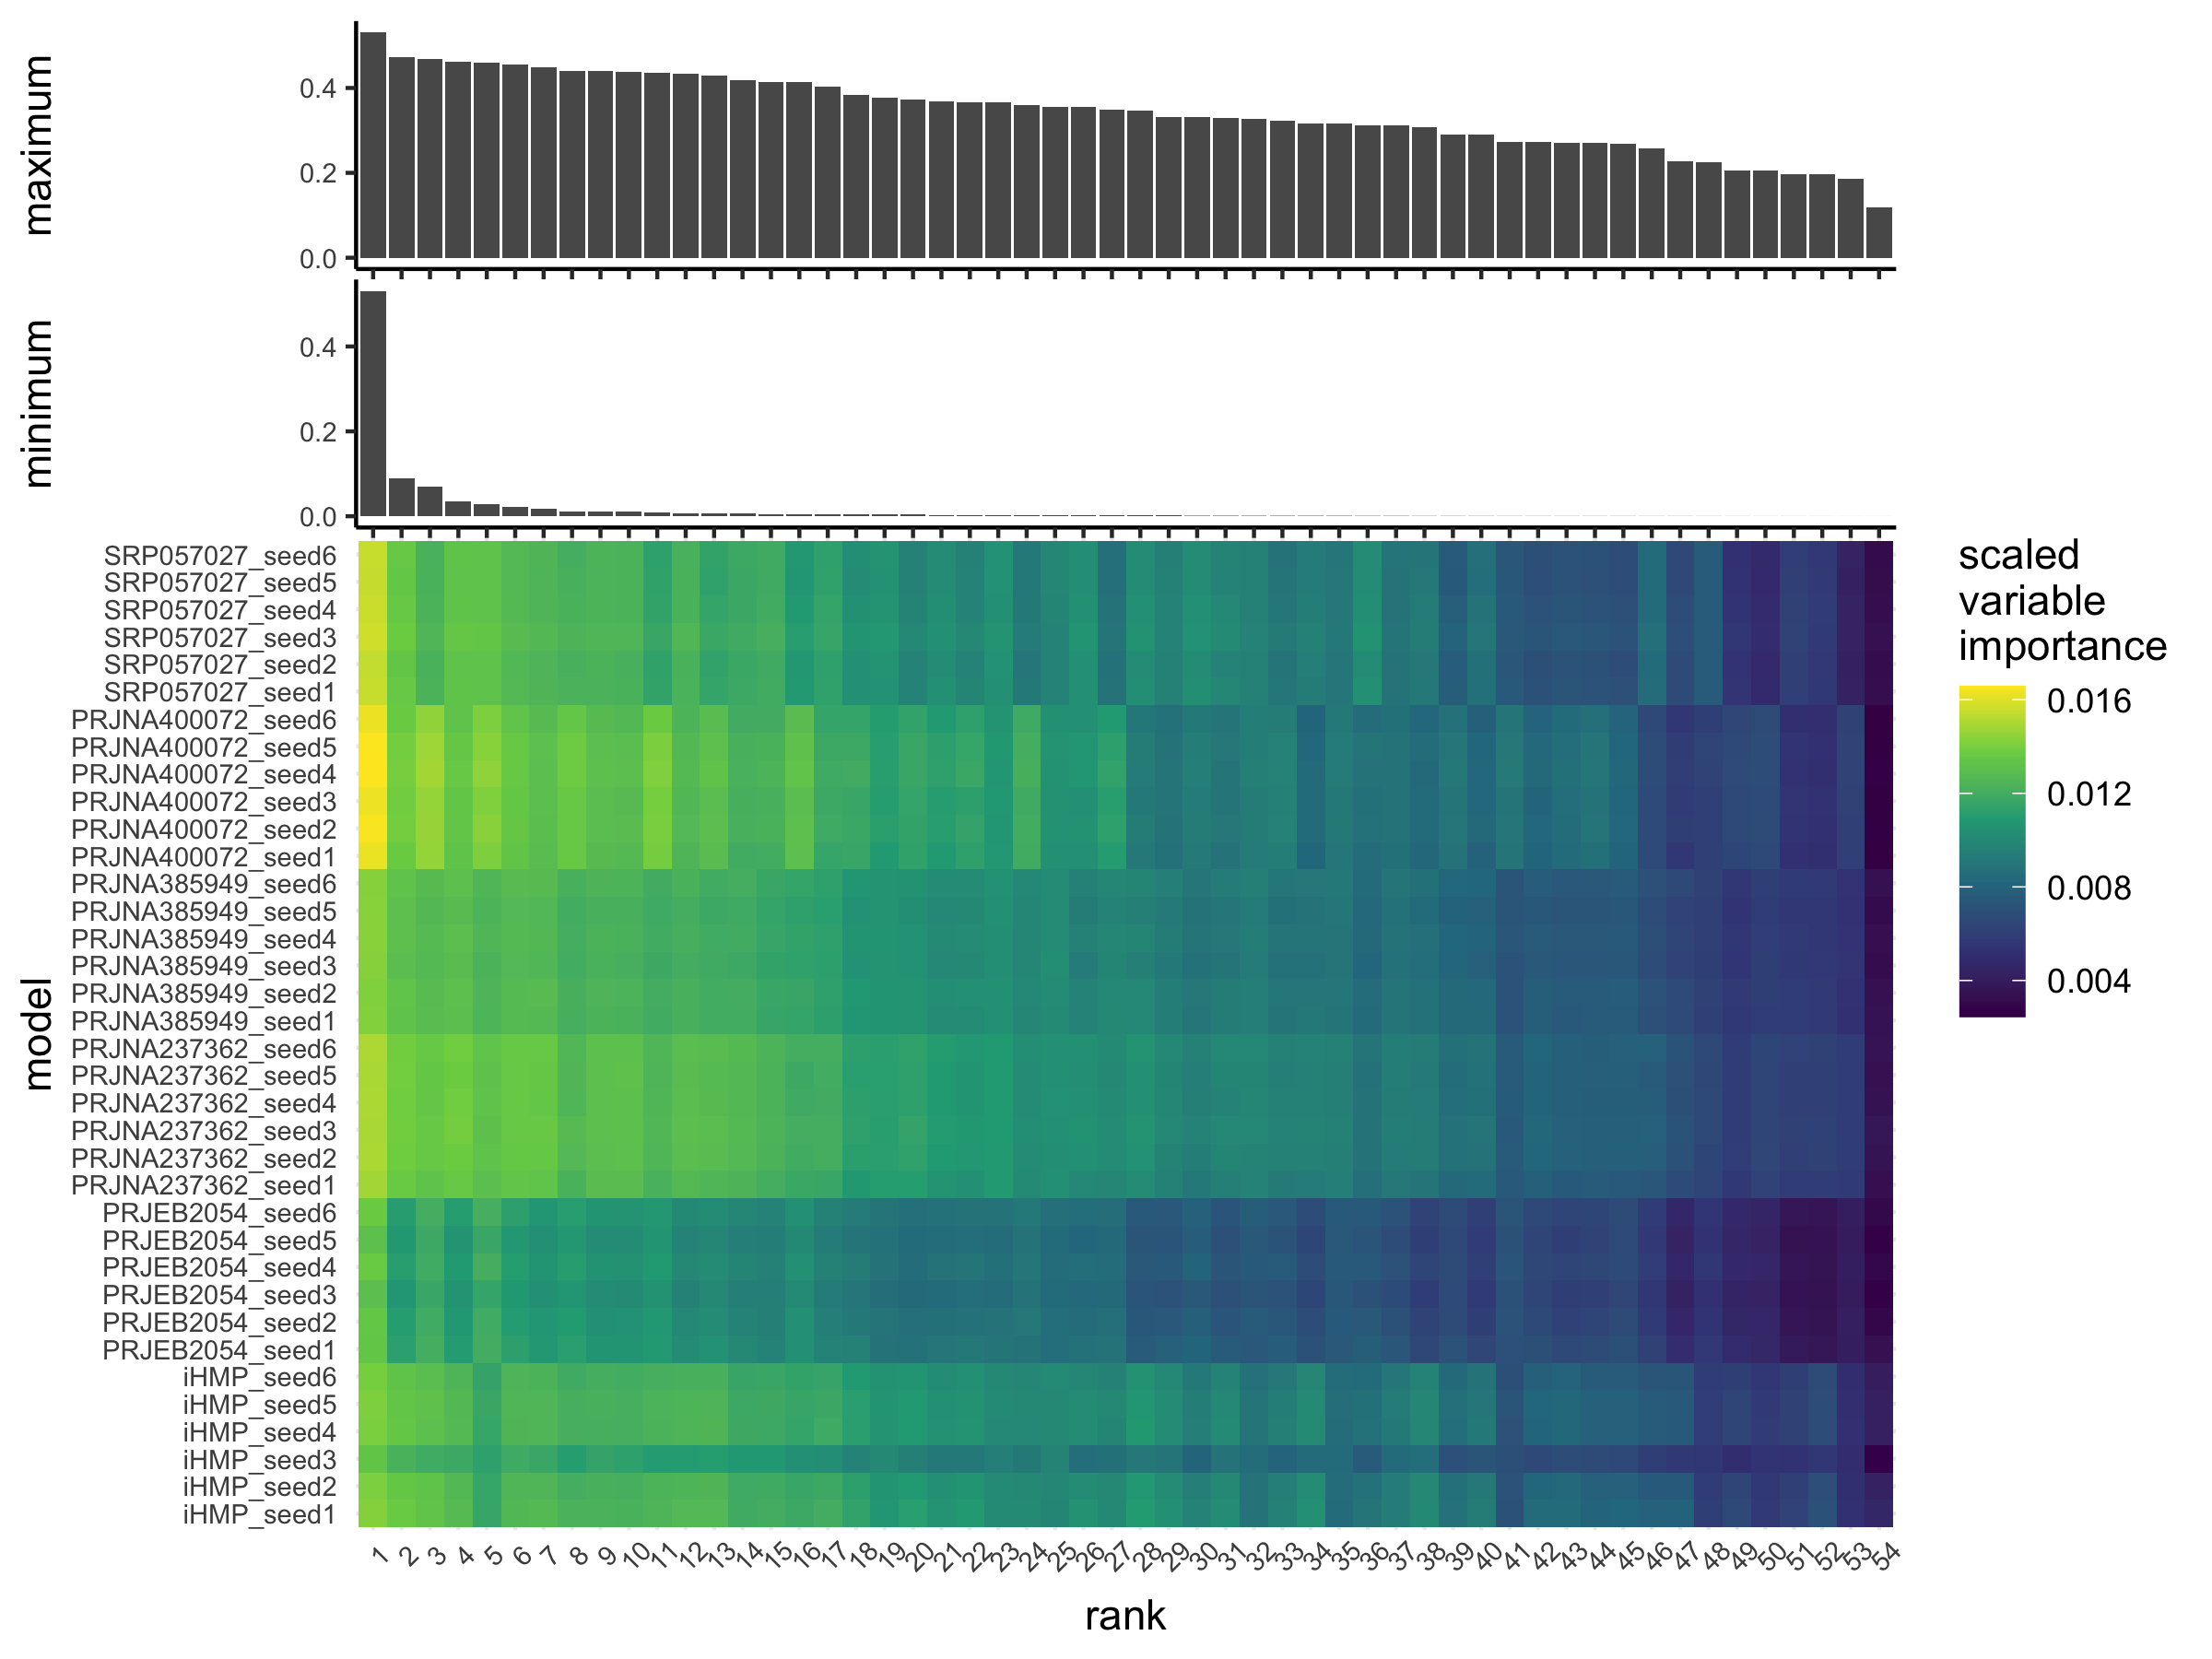

In [24]:
# adjust plot size rendered inline
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

# pdf("figures/cumulative_variable_importance_top54_query_nbhds.pdf", height = 6, width =8)
cumulative_varimp_min_plt %>%
  insert_bottom(per_model_varimp_plt, height = 4) %>%
  insert_top(cumulative_varimp_max_plt)
# dev.off()

### make an upset plot of shared hashes by genome, with barchart of

In [25]:
varimp <- varimp %>%
  mutate(name = ifelse(is.na(name), "unassigned", name))

In [26]:
varimp_split <- varimp %>%
  filter(all_model_norm_imp != 0) %>%
  group_split(name)

In [27]:
varimp_list <- lapply(varimp_split, function(x) x$hash)
names(varimp_list) <- sapply(varimp_split, function(x) unique(x$name))

In [28]:
upset_df_hash <- UpSetR::fromList(varimp_list)

In [29]:
hash_occurrence <- rowSums(upset_df_hash) 
hash_occurrence <- data.frame(num_shared_pangenomes = hash_occurrence, hash = unique(unlist(varimp_list)))
plt1 <- ggplot(hash_occurrence, aes(x = num_shared_pangenomes)) +
  geom_histogram(bins = 54) +
  theme_minimal() +
  labs(x = "number of shared query nbhds")

In [30]:
varimp_to_join <- varimp %>%
  select(hash, all_model_norm_imp) %>%
  distinct() %>%
  filter(all_model_norm_imp != 0) %>%
  group_by(hash) %>%
  summarize(total_imp = sum(all_model_norm_imp)) %>%
  ungroup()

In [31]:
hash_occurrence <- left_join(hash_occurrence, varimp_to_join)

Joining, by = "hash"


In [32]:
tmp <- hash_occurrence %>% 
  group_by(num_shared_pangenomes) %>%
  summarize(sum_total_imp = sum(total_imp))

In [33]:
plt2 <- ggplot(tmp, aes(x = num_shared_pangenomes, y = sum_total_imp)) +
  geom_col() +
  theme_minimal() +
  theme(axis.text.x = element_blank(),
        axis.title.x = element_blank()) +
  labs(y = "cumulative scaled\nvariable importance")

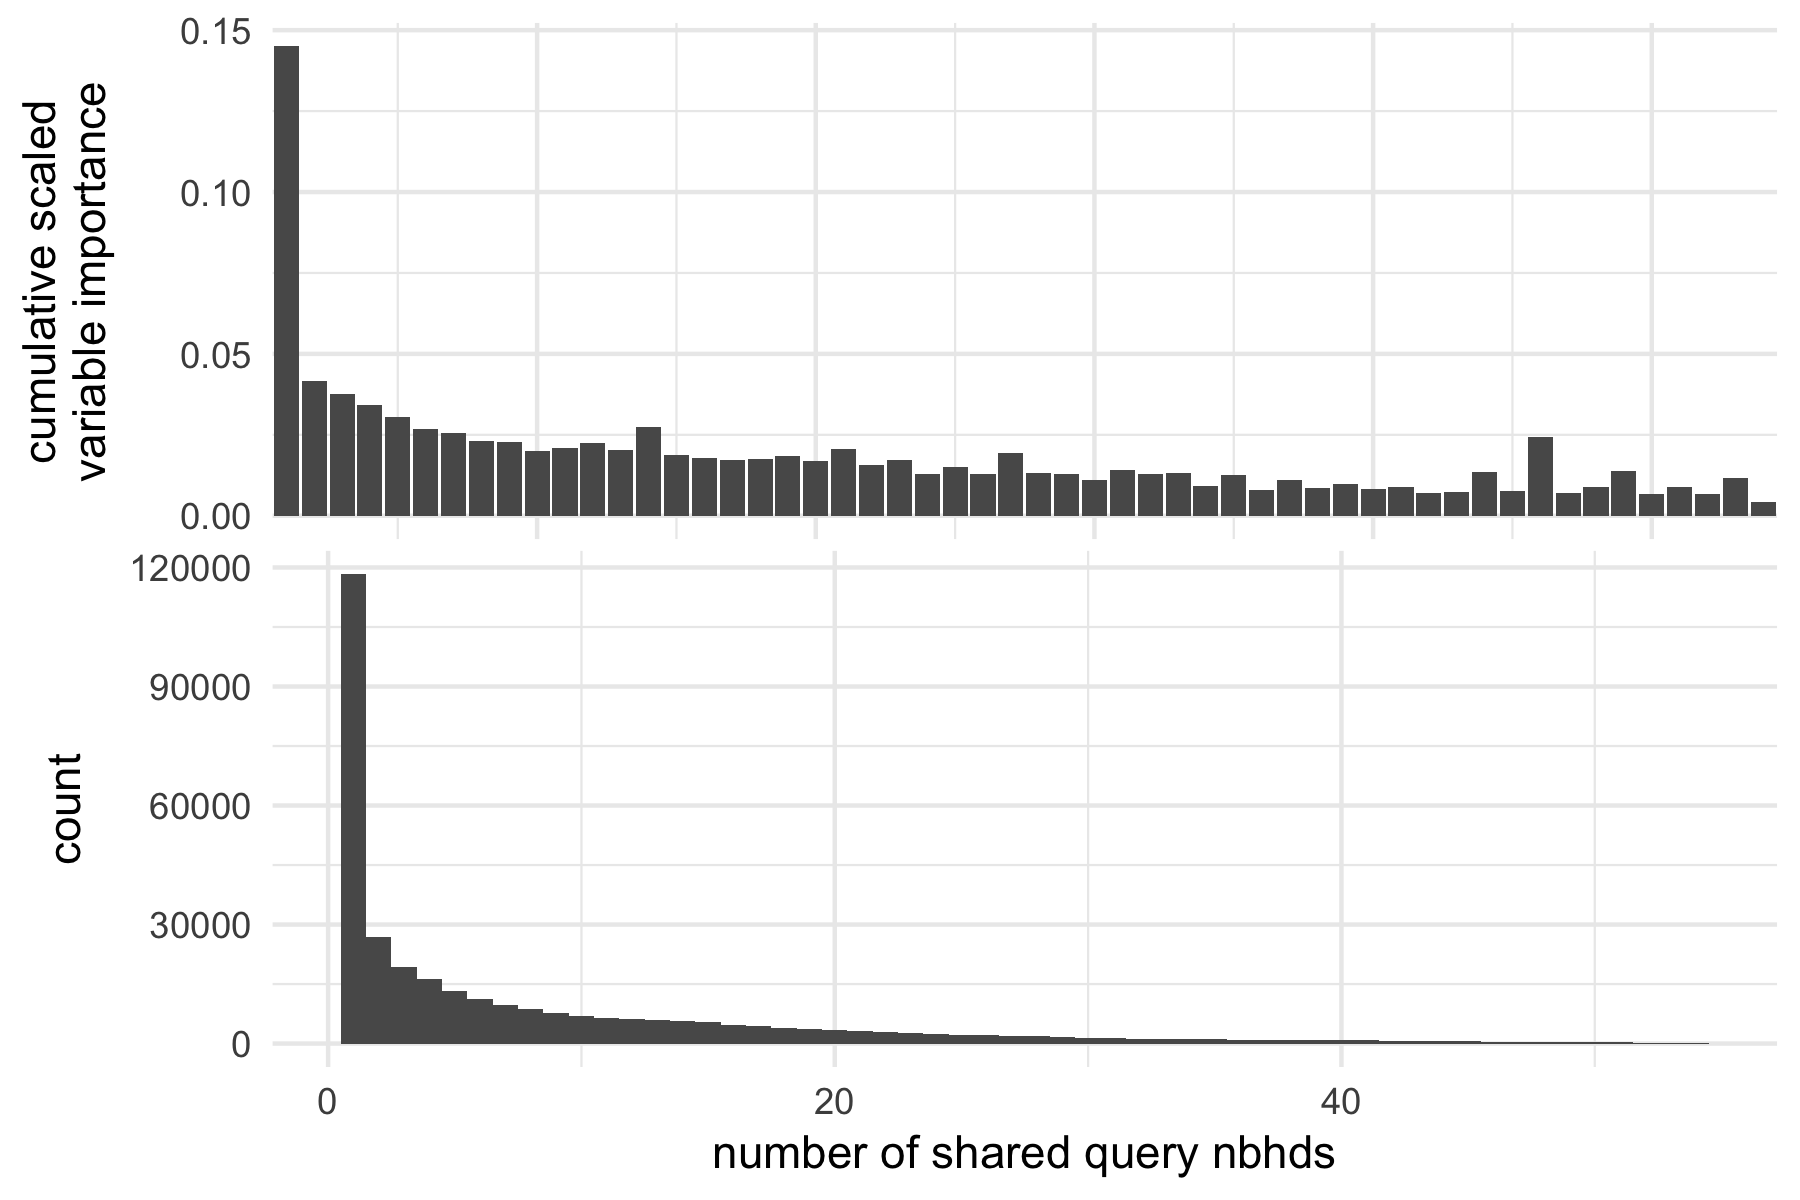

In [34]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

#pdf("figures/query_nbhd_shared_kmers_w_varimp.pdf", height = 4, width = 6)
plt1 %>%
  insert_top(plt2)
#dev.off()

In [39]:
#upset_df_hash$hash <- unique(unlist(varimp_list))
# join with variable importance
#varimp_to_join <- varimp %>%
#   select(hash, all_model_norm_imp) %>%
#   filter(all_model_norm_imp != 0) %>%
#   distinct()
#upset_df_hash <- left_join(upset_df_hash, varimp_to_join)
# 
#pangenomes = names(tmp)
# pdf("tmp.pdf", height = 10, width = 50)
#ComplexUpset::upset(upset_df_hash, pangenomes, sort_intersections_by='degree',
#                     set_sizes=FALSE, name=NULL, width_ratio = 0.1,
#                     base_annotations=list('k-mers'=intersection_size(counts=FALSE)),            
#                     annotations = list('cumulative importance'=list(
#                       aes=aes(x=intersection, all_model_norm_imp),
#                       geom=list(geom_bar(stat='identity')))))
# dev.off()